<a href="https://colab.research.google.com/github/mgswiss15/deepul/blob/2023/Homework_1_Autoregressive_Models_Q2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
    !if [ -d deepul ]; then rm -Rf deepul; fi
    !git clone https://github.com/mgswiss15/deepul.git
    !git checkout 2023
    !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
    !pip install ./deepul
# else:
#     !pwd
#     !pip install ../../../deepul

Cloning into 'deepul'...
remote: Enumerating objects: 1513, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1513 (delta 18), reused 45 (delta 8), pack-reused 1447
Receiving objects: 100% (1513/1513), 129.95 MiB | 22.63 MiB/s, done.
Resolving deltas: 100% (845/845), done.
fatal: not a git repository (or any of the parent directories): .git
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=16663 sha256=0a0c18a36e6a3f767260e3b8de669fd348683897b08174de7d4d6f77e40911e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-cowy88qq/wheels/ce/c2/d6/4d69bb00cfa0c828c46da8c4632fd88db08d755964dd153738
Successfully built deepul


In [3]:
from deepul.hw1_helper import *

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

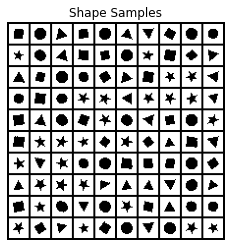

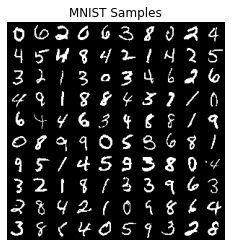

In [4]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaskedW(nn.Linear):
  """Linear layer with masking of type W from MADE.

  Ensures autoregressive masking through random masking of connections.
  Use for the first and all intermediate layers.

  Args:
    d (int): number of input dimensions
    mk_in (torch.tensor): (in_features,) with mk from previous layer
    out_features (int): number of outputs

  Attributes (on top of nn.Linear):
    mk_out (torch.tensor): mk values of output layer
    mask (torch.tensor): masking matrix for nn.Linear.weight
  """
  def __init__(self, d, mk_in, out_features):
    # init linear layer
    in_features = len(mk_in)
    super().__init__(in_features, out_features)
    # output layer connections
    # dims encoded as {0, ... , d-1} hence mk must be in {0, ..., d-2}
    # torch.randing upper bound is exclusive
    self.mk_out = torch.randint(d-1, size=(out_features,))
    # get mask
    mask = torch.ge(self.mk_out[:,None].expand(-1, in_features), mk_in.expand(out_features,-1))
    self.register_buffer('mask', mask)
  
  def forward(self, x):
    return F.linear(x, self.weight * self.mask, self.bias)

class MaskedV(nn.Linear):
  """Linear layer with masking of type V from MADE.

  Ensures autoregressive masking through random masking of connections.
  Use as the final layer

  Args:
    mk_in (torch.tensor): (in_features,) with mk from previous layer
    out_features (int): number of outputs = number of input dims

  Attributes (on top of nn.Linear):
    mask (torch.tensor): masking matrix for nn.Linear.weight
  """
  def __init__(self, mk_in, out_features):
    # init linear layer
    in_features = len(mk_in)
    super().__init__(in_features, out_features)
    # output layer connections
    mk_out = torch.arange(out_features)
    # get mask
    mask = torch.gt(mk_in.expand(out_features,-1), mk_out[:,None].expand(-1, in_features))
    self.register_buffer('mask', mask)
  
  def forward(self, x):
    return F.linear(x, self.weight * self.mask, self.bias)

class Made(nn.Module):
  """MADE reimplemented from Germain et al (2015).

  Ensures autoregressive masking through random masking of connections.
  Use as the final layer

  Args:
    d (int): number of input dimensions
    hiddens (list): size of hidden layers
  """
  def __init__(self, d, hiddens):
    super().__init__()
    self.layers = nn.ModuleList()
    mk_in = torch.arange(d)
    for i, h_size in enumerate(hiddens):
      wlayer = MaskedW(d, mk_in, h_size)
      mk_in = wlayer.mk_out
      self.layers.append(wlayer)
      self.layers.append(nn.ReLU())
    vlayer = MaskedV(mk_in, d)
    self.layers.append(vlayer)
  
  def forward(self, x):
    for l in self.layers:
      x = l(x)
    return x


In [103]:
def q2_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
  
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    import itertools
    from torch.utils.data import DataLoader, TensorDataset

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # move from numpy to torch
    train_data = torch.from_numpy(train_data).flatten(1).float()
    test_data = torch.from_numpy(test_data).flatten(1).float()
    # get dat dims
    n_train, d = train_data.shape
        
    # data loading
    b_size = 256
    train_ds = TensorDataset(train_data)
    test_ds = TensorDataset(test_data)
    train_loader = DataLoader(train_ds, batch_size = b_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size = b_size, shuffle=False)

    # model
    if dset_id == 1:
      made = Made(d, [64, 128, 64]).to(device)
    else:
      made = Made(d, [64, 128, 128, 64]).to(device)

    # loss
    def get_nll(input, target):
        return F.binary_cross_entropy_with_logits(input, target)

    # test loss - simple evaluatoin over test data
    def get_testnll():
        with torch.no_grad():
            for i, batch in enumerate(test_loader):
                nll = 0
                batch = batch[0].to(device)
                nll += get_nll(made(batch), batch).item()
            nll_test = nll / i
        return nll_test
    
    # optimizer
    lr = 0.01 if dset_id == 1 else 0.001
    optimizer = optim.Adam(made.parameters(), lr=lr) 
    
    # training loop
    n_epochs = 1000 if dset_id == 1 else 1000
    nll_train = []
    nll_test = [get_testnll()]
    for epoch in range(n_epochs):
        for batch in train_loader:
            optimizer.zero_grad(set_to_none=True)
            batch = batch[0].to(device)
            # apply model
            logits = made(batch)
            # get loss
            nll = get_nll(logits, batch)
            # sgd step
            nll.backward()
            optimizer.step()
            # monitor train nll
            nll_train.append(nll.item())
        # monitor test nll
        nll_test.append(get_testnll())
        if epoch % 100 == 0:
            print(f'Epoch {epoch}')
    
    # generate samples
    b_size = 100
    samples = torch.randint(2, size = (b_size, d)).float().to(device)
    for i in range(d):
      # get prob of respoective dimension
      logits = made(samples)
      probs = torch.sigmoid(logits)
      smpl = torch.bernoulli(probs[:,i])
      samples[:,i] = smpl

    samples = samples.view(b_size, *(image_shape), 1).detach().to("cpu")
    samples = samples.numpy()

    return nll_train, nll_test, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Final Test Loss: 0.0007


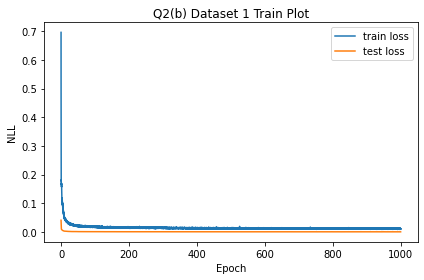

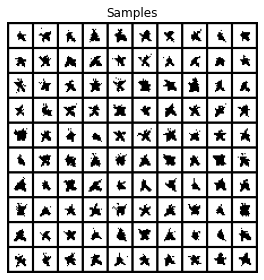

In [99]:
q2_save_results(1, 'b', q2_b)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Final Test Loss: 0.0012


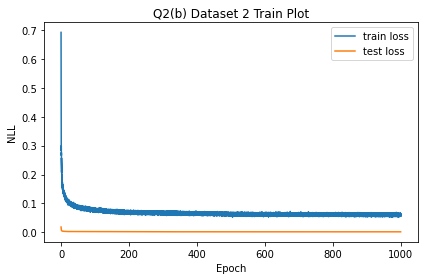

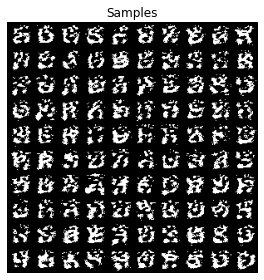

In [104]:
q2_save_results(2, 'b', q2_b)